# Projet détection d'objets avec Pytorch
---
Ce projet porte sur la détection d'objets avec PyTorch, une tâche qui consiste à identifier les objets présents dans une image et à déterminer leur position précise. Contrairement à la simple classification, cette méthode localise chaque élément, ce qui est crucial pour des technologies comme la conduite autonome.

In [369]:
# import
import torch
import torch.nn as nn
import timm
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import ToTensor
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches
import json

In [370]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset COCO
---

In [371]:
# Convertir en tensor et normaliser + data augmentation
mean = torch.tensor([123.675/255.0, 116.28/255.0, 103.53/255.0])
std  = torch.tensor([58.395/255.0, 57.12/255.0, 57.375/255.0])

transform_train = transforms.Compose([
    transforms.RandomCrop(128, padding=4),
    transforms.RandomHorizontalFlip(0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [372]:
from torchvision.datasets import CocoDetection

train_set = CocoDetection(
    root=r"C:\Users\Utilisateur\Simplon\dataset_COCO\train2017",
    annFile=r"C:\Users\Utilisateur\Simplon\dataset_COCO\annotations\instances_train2017.json",
    transform=transform_train
    )

test_set = CocoDetection(
    root=r"C:\Users\Utilisateur\Simplon\dataset_COCO\val2017",
    annFile=r"C:\Users\Utilisateur\Simplon\dataset_COCO\annotations\instances_val2017.json",
    transform=transform_train
    )


trainloader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                         shuffle=False)

loading annotations into memory...
Done (t=151.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


In [373]:
coco_labels_path = r"C:\Users\Utilisateur\Simplon\dataset_COCO\annotations\instances_val2017.json"
with open(coco_labels_path) as f:
    coco_json = json.load(f)

categories = {cat['id']: cat['name'] for cat in coco_json['categories']}
print(categories)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

In [374]:
N = 5

for i in range(N):
    print(train_set[i][1][0]["bbox"], train_set[i][1][0]["category_id"], categories[train_set[i][1][0]["category_id"]])

[1.08, 187.69, 611.59, 285.84] 51 bowl
[385.53, 60.03, 214.97, 297.16] 25 giraffe
[204.86, 31.02, 254.88, 324.12] 64 potted plant
[0.96, 20.06, 441.23, 379.15] 24 zebra
[0.0, 50.12, 457.68, 430.35] 28 umbrella


## Visualisation N random images

73.89 137.22 24.94 57.57
76.22 438.21 86.3 201.35
189.25 323.98 273.82 103.02
1.44 0.72 475.68 575.14
193.27 351.74 18.01 45.04


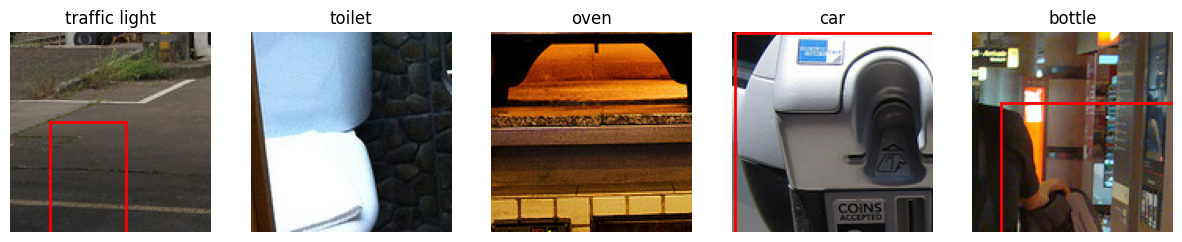

In [375]:
N = 5

def show_images(N, dataset):
    fig, axes = plt.subplots(1, N, figsize=(15, 5))

    for i in range(N):
        idx = np.random.randint(0, len(dataset))
        
        img_tensor, target = dataset[idx]  # CocoDetection returne (image, target)
        box = target[0]["bbox"]
        x1, y1, x2, y2 = box[0], box[1], box[2], box[3]  # float числа
        print(x1, y1, x2, y2)
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        label = categories[target[0]['category_id']]

        img = img_tensor.clone() 
        img = img * std[:, None, None] + mean[:, None, None]  # обратная нормализация
        img = img.clamp(0, 1)  # значения в диапазоне [0,1]
        img = img.permute(1, 2, 0).numpy()  # C,H,W -> H,W,C
        axes[i].add_patch(rect)
        axes[i].imshow(img)

        axes[i].set_title(label if target else 'None')  
        axes[i].axis('off')

    plt.show()


show_images(N, train_set)

## 

## EfficientNet

In [376]:
import timm
import torch.nn as nn

# pre-trained EfficientNet
backbone_model = timm.create_model('efficientnet_b0', pretrained=True)



In [377]:
from tabulate import tabulate

table = []
for i, (name, layer) in enumerate(backbone_model.named_children()):
    table.append([i, name, str(layer)])

# Вывод в виде таблицы
print(tabulate(table, headers=["№", "Layer name", "Description"], tablefmt="fancy_grid"))

╒═════╤══════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│   № │ Layer name   │ Description                                                                                                     │
╞═════╪══════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│   0 │ conv_stem    │ Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)                                    │
├─────┼──────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│   1 │ bn1          │ BatchNormAct2d(                                                                                                 │
│     │              │   32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True                                            │
│     │              │   (drop): Identity

In [378]:
# Предобученный EfficientNet
backbone_model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=1000
).to(device)
backbone_model.eval()

# ImageNet transforms (ОБЯЗАТЕЛЬНО)
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open("img_test.jpg").convert("RGB")
x = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    logits = backbone_model(x)

print("logits shape:", logits.shape, logits)  # [1, 1000]

logits shape: torch.Size([1, 1000]) tensor([[-1.4069e+00,  2.8595e-02, -2.4965e-01,  5.3654e-01, -8.2498e-01,
          3.7443e-01, -1.3227e+00, -2.1748e-01,  2.1842e-02, -8.5475e-01,
          3.2703e-01, -1.9155e+00, -1.0529e+00, -3.5022e-01, -8.0640e-01,
         -8.5897e-01,  1.0264e+00, -1.3819e+00, -9.8916e-01, -4.9006e-01,
          1.0313e+00,  4.6210e-02, -7.1897e-01, -1.3277e-01,  3.1005e-01,
         -5.7957e-02,  1.9783e+00, -1.0997e-01,  1.5649e+00, -2.4599e-01,
         -1.3870e+00, -2.4822e-01,  8.3274e-02, -8.3785e-02,  1.5213e+00,
         -2.9003e-01,  1.1340e+00,  2.0847e-02,  1.3157e+00,  6.3507e-02,
         -1.4010e-01,  5.4790e-01, -6.7066e-01, -1.4711e-01,  1.1476e+00,
          3.2068e-01, -3.5478e-01,  2.0347e+00, -1.4912e+00, -8.3206e-01,
         -9.6595e-01, -7.9451e-01,  3.3991e-01, -6.4781e-01, -4.2356e-01,
         -4.3195e-01,  1.2870e-01, -4.4965e-01, -1.5265e+00,  7.2082e-01,
         -7.0393e-01, -2.9337e+00,  3.8025e-04,  5.9933e-01,  2.2323e-01,
  

## MyEffNetClassifier with backbone

In [379]:

class EfficientDetRCNN(nn.Module):
    """
    Faster R-CNN avec EfficientNet-B0 backbone + FPN .
    """
    def __init__(self, num_classes=91, pretrained_backbone=True):
        super().__init__()
        
        # 1️⃣ EfficientNet-B0 backbone
        effnet = timm.create_model('efficientnet_b0', pretrained=pretrained_backbone)
        
        # Используем только feature extractor (убираем head)
        backbone = nn.Sequential(*list(effnet.children())[:-2])
        backbone.out_channels = 1280  # последний conv слой EfficientNet-B0
        
        # 2️⃣ Feature Pyramid Network
        # Мы используем один feature map, поэтому размеры anchor должны быть кортежем кортежей
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),    # для одного feature map
            aspect_ratios=((0.5, 1.0, 2.0),)
        )
        
        # 3️⃣ Создаём Faster R-CNN
        self.model = FasterRCNN(
            backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator
        )
    
    def forward(self, images, targets=None):
        """
        images: list of tensors [3,H,W] в диапазоне [0,1]
        targets: list of dict {'boxes': Tensor[N,4], 'labels': Tensor[N]}
        """
        if self.training:
            if targets is None:
                raise ValueError("Targets required in training mode")
        return self.model(images, targets)

In [380]:
detector = EfficientDetRCNN(num_classes=num_classes)
detector.to(device)
detector.eval()

EfficientDetRCNN(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (2): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_re

In [381]:
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
from PIL import Image


#  Test image
img_path = "img_test.jpg"  # path
img = Image.open(img_path).convert("RGB")

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
])
img_tensor = transform(img).to(device) 
with torch.no_grad():
    outputs = detector([img_tensor])




In [382]:
print(outputs[0]["labels"])

tensor([58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 69, 58, 58, 58, 69, 58,
        69, 58, 58, 58, 58, 58, 58, 58, 69, 69, 58, 58, 58, 58, 58, 69, 58, 58,
        58, 69, 58, 58, 71, 58, 58, 58, 58, 58, 58, 58, 58, 58, 69, 58, 58, 71,
        58, 58, 69, 58, 58, 58, 58, 69, 69, 69, 69, 69, 58, 58, 58, 58, 58, 58,
        69, 58, 58, 69, 68, 71, 69, 70, 69, 69, 58, 58, 58, 58, 58, 70, 69, 69,
        89, 58, 58, 58, 69, 58, 89, 58, 58, 58], device='cuda:0')


(275, 183)
23.974082946777344 99.61815643310547 25.63011932373047 99.7018814086914 hot dog
21.13548469543457 147.2135772705078 21.19652557373047 147.22525024414062 hot dog
24.413455963134766 97.7952880859375 29.201435089111328 97.79890441894531 hot dog
26.332265853881836 107.55477142333984 26.732568740844727 108.45957946777344 hot dog
58.289100646972656 121.93779754638672 58.356380462646484 133.87510681152344 hot dog
18.883228302001953 155.4832763671875 19.105764389038086 158.0955810546875 hot dog
74.36078643798828 123.85698699951172 77.34208679199219 131.91709899902344 hot dog
0.0 68.43428802490234 121.11781311035156 68.4645767211914 hot dog
41.32575225830078 75.45079040527344 41.33521270751953 75.49249267578125 hot dog
36.933406829833984 104.80164337158203 41.54328536987305 105.4671630859375 hot dog


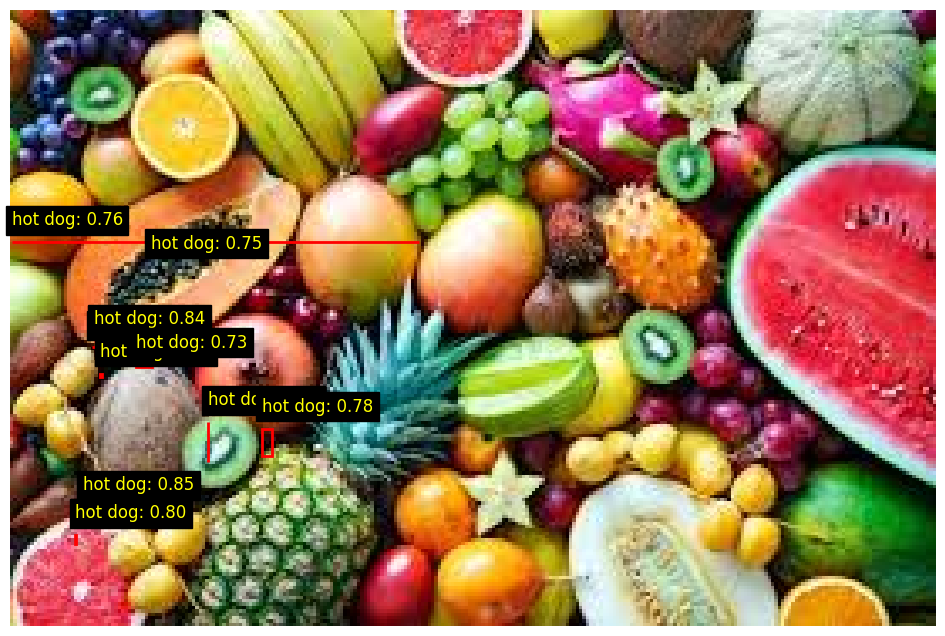

In [383]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)
print(img.size)

boxes = outputs[0]['boxes'].cpu()
labels = outputs[0]['labels'].cpu()
scores = outputs[0]['scores'].cpu()

# Фильтруем детекции с score > 0.5
threshold = 0.7
for box, label, score in zip(boxes, labels, scores):
    if score < threshold:
        continue
    x1, y1, x2, y2 = box.tolist()  # float числа
    print(x1, y1, x2, y2, categories.get(int(label)))
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(
        x1, y1 - 5,
        f"{categories.get(int(label))}: {score:.2f}",
        color='yellow', fontsize=12, backgroundcolor='black'
    )

plt.axis('off')
plt.show()

### Dataset for detector

In [393]:
def collate_fn(batch):
    images, targets_list = zip(*batch)
    new_targets = []

    for t in targets_list:
        if len(t) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor([obj['bbox'] for obj in t], dtype=torch.float32)
            boxes[:, 2] += boxes[:, 0]  # x2 = x + w
            boxes[:, 3] += boxes[:, 1]  # y2 = y + h
            labels = torch.tensor([obj['category_id'] for obj in t], dtype=torch.int64)
        
        new_targets.append({"boxes": boxes, "labels": labels})
        
    return list(images), new_targets

### Dataloader 

In [394]:
trainloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=4,          # детектор требует маленький батч
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

testloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [390]:
from torch import optim

In [395]:
detector.train()



optimizer = optim.AdamW(detector.parameters(), lr=1e-4)
num_epochs = 3

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, targets in trainloader:
        # Перенос на device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        
        # Faster R-CNN возвращает dict потерь
        loss_dict = detector(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss/len(trainloader):.4f}")

print("Тренировка завершена.")

ValueError: Required crop size (128, 128) is larger than input image size (112, 648)

In [ ]:
detector.eval()
with torch.no_grad():
    outputs = detector([img_tensor.to(device)])